# This code uses the new discrete code

In [1]:
import os
import sys
import collections
import tensorflow as tf
from importlib import reload

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
a = os.path.join(module_path, "strands_qsr_lib\qsr_lib\src3")

sys.path.append(a)

## PLOTTING 
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
import plotting


### IMPORT FROM CURRENT PROJECT
import progress_learner
import config
import project
from project import Project

### RL module
from rl import action_learner, action_learner_search, value_estimator
from rl import block_movement_env
from rl import discrete_value_estimator as  dve
from rl import discrete_action_learner as dal

C:\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
reload(dal)
dal._test_get_action_from_quantized_states()

The action from (2, 1) to (1, 0) is illegal
The action 2 from (2, 1) to (2, 0)
The action from (2, 1) to (3, 0) is illegal
The action 3 from (2, 1) to (1, 1)
The action 0 from (2, 1) to (2, 1)
The action 1 from (2, 1) to (3, 1)
The action from (2, 1) to (1, 2) is illegal
The action 4 from (2, 1) to (2, 2)
The action from (2, 1) to (3, 2) is illegal


In [3]:
dal._test_realize_action()

quantized (1, 1.0)
action [0.4767767 0.5767767 0.       ]
requantized (0, 1.0)
action [0.65355339 0.75355339 0.        ]
requantized (1, 1.0)
action [0.55 0.4  0.  ]
requantized (0, 0.0)
action [0.83033009 0.93033009 0.        ]
requantized (2, 1.0)
action [0.3  0.65 0.  ]
requantized (0, 2.0)


In [12]:
### RELOAD modules here
reload(config)
reload(value_estimator)
reload(config)
reload(block_movement_env)
reload(action_learner_search)
reload(progress_learner)
reload(dal)
reload(dve)


### MAIN CODE
tf.reset_default_graph()

c = config.Qual_Plan_Config()

global_step = tf.Variable(0, name="global_step", trainable=False)


policy_est = dve.DiscretePolicyEstimator(c)
value_est = dve.ValueEstimator(c)

sess =  tf.Session()

sess.run(tf.global_variables_initializer())

projects = {}
progress_estimators = {}

# action_types = ["SlideToward", "SlideAway", "SlideNext", "SlidePast", "SlideAround"]
action_types = ["SlideAround"]

for project_name in action_types:
    print ('========================================================')
    print ('Load for action type = ' + project_name)
    p_name = project_name.lower() + "_project.proj"

    projects[project_name] = project.Project.load(os.path.join('..' , 'learned_models', p_name))

    with tf.variable_scope("model") as scope:
        print('-------- Load progress model ---------')
        progress_estimators[project_name] = progress_learner.EventProgressEstimator(is_training=True,
                                                                                    is_dropout = False, 
                                                                                    name = projects[project_name].name, 
                                                                                    config = c)  

# Print out all variables that would be restored
for variable in tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='model'):
    print (variable.name)

for project_name in action_types:
    saver = tf.train.Saver(tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='model/' + project_name))

    saver.restore(sess, os.path.join('..' , 'learned_models', 'progress_' + project_name + '.mod.1'))

Load for action type = SlideAround
-------- Load progress model ---------
self.inputs.shape = (?, 20, 200)  after linear layer
output.shape = (30, 200) after LSTM
self.output.shape = (30,) after linear
self._targets.shape = (?,) 
model/SlideAround/Variable:0
model/SlideAround/linear/weight:0
model/SlideAround/linear/bias:0
model/SlideAround/lstm/rnn/multi_rnn_cell/cell_0/basic_lstm_cell/kernel:0
model/SlideAround/lstm/rnn/multi_rnn_cell/cell_0/basic_lstm_cell/bias:0
model/SlideAround/output_linear/weight:0
model/SlideAround/output_linear/bias:0
model/SlideAround/beta1_power:0
model/SlideAround/beta2_power:0
model/SlideAround/model/SlideAround/linear/weight/Adam:0
model/SlideAround/model/SlideAround/linear/weight/Adam_1:0
model/SlideAround/model/SlideAround/linear/bias/Adam:0
model/SlideAround/model/SlideAround/linear/bias/Adam_1:0
model/SlideAround/model/SlideAround/lstm/rnn/multi_rnn_cell/cell_0/basic_lstm_cell/kernel/Adam:0
model/SlideAround/model/SlideAround/lstm/rnn/multi_rnn_cell/

In [22]:
reload(dal)
c.num_episodes = 1
action_ln = dal.DiscreteActionLearner(c, projects['SlideAround'], progress_estimators['SlideAround'], 
                               policy_est, value_est, session = sess, limit_step = 10)

past_envs, stats = action_ln.policy_learn(dal.random_action, breadth = 1, verbose = True,
                                          choice = 'ACTOR_CRITIC', default = False)

value = 1, region = 0
1 0 0 25
action_probs [0.21914446 0.20805344 0.18882191 0.19505984 0.18892042]
Debug (1, 0.0) 3 (0, 0.0)
Exception in episode 0 


Traceback (most recent call last):
  File "D:\git\learn-to-perform\rl\discrete_action_learner.py", line 449, in policy_learn
    elif action == 0 and t > 0:
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


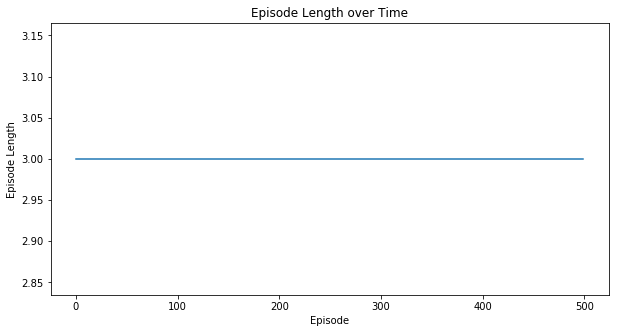

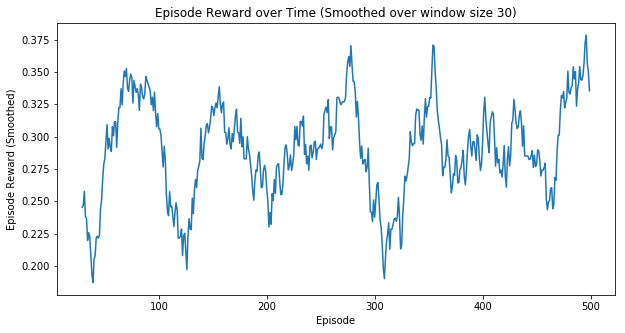

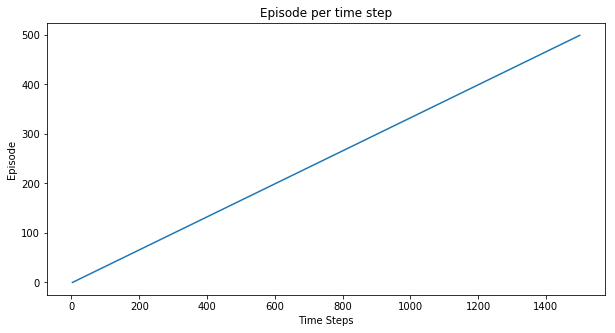

(<matplotlib.figure.Figure at 0x23e1da5f710>,
 <matplotlib.figure.Figure at 0x23e1134ccf8>)

In [119]:
plotting.plot_episode_stats(stats, smoothing_window=30)

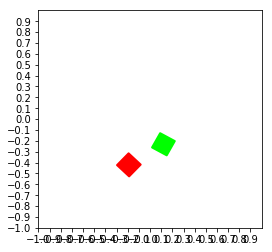

(None, None)
[-0.09898599 -0.11082094  1.06630699]
[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [-1.  0. -1.  0. -1.  0.  0.]
 [ 0. -1. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0.  0.  0. -1.  0.  0.]
 [ 0.  0.  0.  0. -1.  0.  0.]
 [-1.  0.  1.  0. -1.  0.  0.]
 [ 0.  0.  1.  0. -1.  0.  0.]]
Progress = 0.44; reward = 0.44


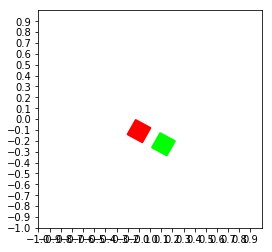

(None, None)
[0.05056212 0.00853992 1.06630699]
[[ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [-1.  0. -1.  0. -1.  0.  0.]
 [ 0. -1. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0.  0.  0. -1.  0.  0.]
 [-1.  0.  1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0.  0.  0. -1.  0.  0.]
 [ 0.  0.  1.  0. -1.  0.  0.]
 [-1.  0.  1.  0. -1.  0.  0.]
 [ 0.  0.  1.  0. -1.  0.  0.]]
Progress = 0.60; reward = 0.17


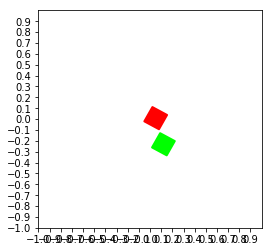

(None, None)
[0.05056212 0.00853992 1.06630699]
[[ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [-1.  0. -1.  0. -1.  0.  0.]
 [ 0. -1. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0.  0.  0. -1.  0.  0.]
 [-1.  0.  1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0.  0.  0. -1.  0.  0.]
 [ 0.  0.  1.  0. -1.  0.  0.]
 [-1.  0.  1.  0. -1.  0.  0.]
 [ 0.  0.  1.  0. -1.  0.  0.]]
Progress = 0.60; reward = 0.00


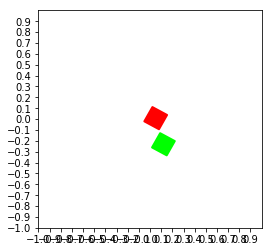

(None, None)
[-0.09898599 -0.11082094  1.06630699]
[[ 0.  0. -1.  0. -1.  0.  0.]
 [-1.  0. -1.  0. -1.  0.  0.]
 [ 0. -1. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [-1.  0.  1.  0. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0.  1.  0. -1.  0.  0.]
 [-1.  0.  1.  0. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0. -1.  0.  1.  0.  0.]
 [ 0.  0. -1.  0.  1.  0.  0.]
 [ 0.  0. -1.  0.  1.  0.  0.]
 [ 0.  0.  1.  0.  1.  0.  0.]]
Progress = 0.02; reward = -0.58


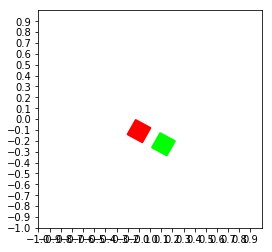

(None, None)
[-0.09898599 -0.11082094  1.06630699]
[[ 0.  0. -1.  0. -1.  0.  0.]
 [-1.  0. -1.  0. -1.  0.  0.]
 [ 0. -1. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [-1.  0.  1.  0. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0.  1.  0. -1.  0.  0.]
 [-1.  0.  1.  0. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0. -1.  0.  1.  0.  0.]
 [ 0.  0. -1.  0.  1.  0.  0.]
 [ 0.  0. -1.  0.  1.  0.  0.]
 [ 0.  0.  1.  0.  1.  0.  0.]]
Progress = 0.02; reward = 0.00


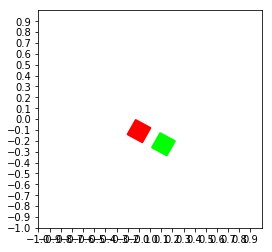

In [21]:
past_envs[0].env.replay(verbose = True)

In [5]:
reload(block_movement_env)
#reload(progress_learner)
bme = block_movement_env.BlockMovementEnv(c, projects['SlideAround'].speed, projects['SlideAround'].name, 
                progress_estimator = progress_estimators['SlideAround'], session = sess)

In [6]:
bme.default_action()

[-0.75, 0.5, 0.5]


ValueError: Could not flatten dictionary. Key had 4 elements, but value had 1 elements. Key: [<tf.Tensor 'model/SlideAround/MultiRNNCellZeroState/DropoutWrapperZeroState/BasicLSTMCellZeroState/zeros:0' shape=(30, 200) dtype=float32>, <tf.Tensor 'model/SlideAround/MultiRNNCellZeroState/DropoutWrapperZeroState/BasicLSTMCellZeroState/zeros_1:0' shape=(30, 200) dtype=float32>, <tf.Tensor 'model/SlideAround/MultiRNNCellZeroState/DropoutWrapperZeroState/BasicLSTMCellZeroState/zeros:0' shape=(30, 200) dtype=float32>, <tf.Tensor 'model/SlideAround/MultiRNNCellZeroState/DropoutWrapperZeroState/BasicLSTMCellZeroState/zeros_1:0' shape=(30, 200) dtype=float32>], value: [<tf.Tensor 'zeros_like:0' shape=(2, 2, 30, 200) dtype=float32>].

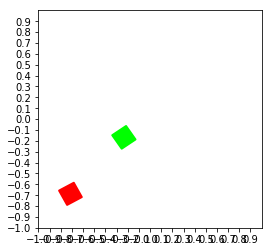

(None, None)
[-0.75  0.5   0.5 ]
[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0. -1. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [-1. -1. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0.  1.  0. -1.  0.  0.]
 [ 0.  0.  1.  0. -1.  0.  0.]
 [ 0.  1.  1.  0. -1.  0.  0.]
 [-1.  0.  1.  0. -1.  0.  0.]
 [ 0.  0.  1.  0. -1.  0.  0.]
 [ 0.  1.  1.  0. -1.  0.  0.]
 [ 0.  0.  1.  0. -1.  0.  0.]
 [ 0.  1.  1.  0. -1.  0.  0.]
 [ 0.  1.  1.  0. -1.  0.  0.]
 [ 0.  0.  1.  0. -1.  0.  0.]
 [ 0.  1.  1.  0. -1.  0.  0.]]
Progress = 0.56; reward = 0.59


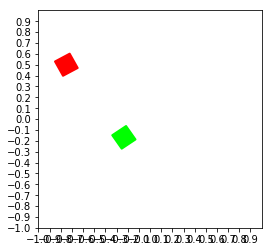

(None, None)
[-0.75  0.5   0.5 ]
[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0. -1. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [-1. -1. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0.  1.  0. -1.  0.  0.]
 [ 0.  0.  1.  0. -1.  0.  0.]
 [ 0.  1.  1.  0. -1.  0.  0.]
 [-1.  0.  1.  0. -1.  0.  0.]
 [ 0.  0.  1.  0. -1.  0.  0.]
 [ 0.  1.  1.  0. -1.  0.  0.]
 [ 0.  0.  1.  0. -1.  0.  0.]
 [ 0.  1.  1.  0. -1.  0.  0.]
 [ 0.  1.  1.  0. -1.  0.  0.]
 [ 0.  0.  1.  0. -1.  0.  0.]
 [ 0.  1.  1.  0. -1.  0.  0.]]
Progress = 0.57; reward = 0.03


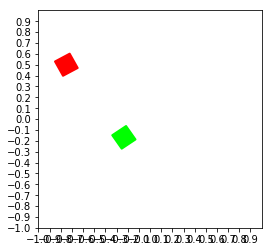

(None, None)
[-0.3   0.55  0.5 ]
[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0. -1. -1.  0. -1.  0.  0.]
 [-1.  0. -1.  0. -1.  0.  0.]
 [ 0. -1. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0.  1.  0. -1.  0.  0.]
 [-1.  1.  1.  0. -1.  0.  0.]
 [ 0.  0.  1.  0. -1.  0.  0.]
 [ 0.  1.  1.  0. -1.  0.  0.]
 [ 0.  1.  1.  0. -1.  0.  0.]
 [ 0.  0.  1.  0. -1.  0.  0.]
 [ 0.  1.  1.  0. -1.  0.  0.]
 [ 0.  0.  1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [-1. -1. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]]
Progress = 0.55; reward = -0.09


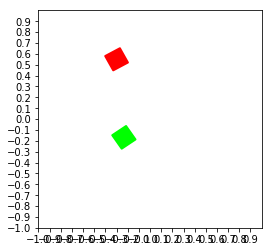

In [120]:
bme.replay(verbose = True)